In [1]:
# ALL IMPORTS
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from random import shuffle
import librosa
import pickle
import librosa.display

In [2]:
### LOAD ALL FILE PATHS TO ARRAY
cwd = os.getcwd()
dataPath = 'data'
pathToData = os.path.join(cwd, dataPath)

# USABLE CLASSES
# bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, right, seven, sheila
# six, stop, three, tree, two, up, wow, yes, zero

# CHANGE THIS TO TRUE/FALSE TO CREATE AUDIO DATA USED FOR TRAINING
PROCESS_ELM = True
# AUDIO CIFAR
if(PROCESS_ELM):
    wordsToTrain = 'bed,bird,cat,dog,tree,wow,house,go,right,left,stop,happy'
    name = 'CIFAR'
# AUDIO MNIST
else:    
    wordsToTrain = 'zero,one,two,three,four,five,six,seven,eight,nine'
    name = 'MNIST'
    
# SPLIT STRING TO FIND CLASSES
wordsToTrain_Array = wordsToTrain.split(',')
numberOfClasses = len(wordsToTrain_Array)

audioFiles = []
labelNames = []
classIndex = -1

# FIND ALL FOLDERS INSIDE THE DATA FOLDER
for classFile in os.listdir(pathToData):
    # FOR ALL FOLDERS FOUND THAT MATCH THE WORDSTOTRAIN
    
    if(classFile in wordsToTrain_Array):
        classIndex += 1
        labelNames.append(classFile)
        # CHECK INSIDE EVERY FOLDER
        pathToClass =  os.path.join(pathToData, classFile)
        # lOOP THROUGH FILES FOUND
        for audioFile in os.listdir(pathToClass):
            # IF THE FILE IS IN WAV MODE
            if(audioFile.endswith('.wav')):
                # APPEND THE FILE PATH AND THE CORRECT LABEL TO THE AUDIO FILES
                audioFiles.append([os.path.join(pathToClass,audioFile),classIndex])
# RANDOMIZE THE ARRAY
shuffle(audioFiles)
print("Number of classes: " + str(numberOfClasses))            

Number of classes: 12


In [3]:
# Note - nearly 1700 datapoints for each class. 
# If limit data is used, reduce the number of files by percentOfData Variable
limitData = False
percentOfData = 0.3

dataPoints = len(audioFiles)
if(limitData):
    dataPoints = int((dataPoints*percentOfData))

# Set size of training
trainingSize = int(0.85 * dataPoints)
# Set size of validation
validationSize = int(0.15 * dataPoints)
# Rest should then be the testing set
# Note - testin set will never be used since we only want to validate the elm
testingSize = int(dataPoints - (trainingSize + validationSize))

print("Number of datapoints are: ",dataPoints)
print("Training samples: ",trainingSize)
print("Validation samples: ",validationSize)
print("Testing samples: ", testingSize)
print("Sum of all sets is ",trainingSize+validationSize+testingSize)


Number of datapoints are:  7009
Training samples:  5957
Validation samples:  1051
Testing samples:  1
Sum of all sets is  7009


In [4]:
# changes a wav format to spectrogram
def fileToSpectrogram(path, seconds=1):
    y, sr = librosa.load(path)
    # Cut the audio to the first 1 seconds
    y = y[:seconds * sr] 
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
    return S    

# Plots up the spectrogram with it's class and name
def plotSpectrogram(spectrogram):
    plt.figure(figsize=(10, 4))
    spectrogramData = spectrogram['data']
    librosa.display.specshow(librosa.power_to_db(spectrogramData, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    splitPath = spectrogram['filename'].split('\\')
    plt.title(spectrogram['labelName'] + "  -  " + splitPath[len(splitPath)-1])
    plt.tight_layout()
    plt.show()
    
def plotNormalizedSpectrogram(normalizedSpecto):
    plt.figure(figsize=(10, 4))
    spectrogramData = normalizedSpecto
    librosa.display.specshow(librosa.power_to_db(spectrogramData, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()
    
def fileObjectToDataObject(fileObject, preProcess = True):
    pathToSoundArray = fileToSpectrogram(fileObject[0])
    meanOfSound = pathToSoundArray.mean() * 0.01
    if(preProcess):
        pathToSoundArray -= meanOfSound
    
    
    targetVector = np.zeros((1,numberOfClasses))[0]
    targetVector[fileObject[1]] = 1
    
    dataObject = {
        'filename' : fileObject[0],
        'data' : pathToSoundArray,
        'label' : targetVector,
        'labelName' : labelNames[fileObject[1]]
    }
    
    return dataObject

In [5]:
# CHANGE DATA TO ARRAY

trainingArray = []
validationArray = []
testingArray = []

# Load training data   # trainingSize
for i in range(trainingSize):
    newObject = fileObjectToDataObject(audioFiles[i])
    trainingArray.append(newObject)
# Load validation   
for i in range(validationSize):
    # Get the correct index
    startIndex = i + trainingSize
    newObject = fileObjectToDataObject(audioFiles[startIndex])

    validationArray.append(newObject)
# Load testing # Not used
for i in range(testingSize):
    # Get the correct index
    startIndex = i + trainingSize + validationSize
    newObject = fileObjectToDataObject(audioFiles[startIndex])
    testingArray.append(newObject)

# Print info about percentage of dataset    
def getArrInfo(anArray, arrName):
    print("Info about dataset " +arrName)
    infoHolder = np.zeros((1,numberOfClasses))[0]
    for i in range(len(anArray)):
        infoHolder += anArray[i]['label']
    
    infoHolder = infoHolder/len(anArray)
    for i in range(numberOfClasses):
        print(str("{:.2%}".format(infoHolder[i])) + " of the dataset is of class " + wordsToTrain_Array[i] )
    print("")
    
getArrInfo(trainingArray, "Training array")    
getArrInfo(validationArray, "Validation array")        
getArrInfo(testingArray, "Testing array")        


Info about dataset Training array
7.07% of the dataset is of class bed
7.30% of the dataset is of class bird
7.55% of the dataset is of class cat
7.87% of the dataset is of class dog
10.48% of the dataset is of class tree
7.44% of the dataset is of class wow
7.54% of the dataset is of class house
9.89% of the dataset is of class go
10.88% of the dataset is of class right
9.82% of the dataset is of class left
7.20% of the dataset is of class stop
6.97% of the dataset is of class happy

Info about dataset Validation array
8.09% of the dataset is of class bed
7.99% of the dataset is of class bird
6.76% of the dataset is of class cat
6.28% of the dataset is of class dog
9.71% of the dataset is of class tree
7.52% of the dataset is of class wow
8.09% of the dataset is of class house
10.47% of the dataset is of class go
9.90% of the dataset is of class right
10.28% of the dataset is of class left
7.33% of the dataset is of class stop
7.61% of the dataset is of class happy

Info about dataset

In [6]:

# Add silence to the dataset
def addSilenceToSet(aDataset, findMax = True):
    maxLen = 0
    minLen = 1000

    maxindex = 0
    minindex = 0
    for i in range(len(aDataset)):
        maxOfData = np.shape(aDataset[i]['data'])[1]
        if(maxOfData > maxLen):
            maxLen = maxOfData
            maxindex = i
        if(maxOfData < minLen):
            minLen = maxOfData
            minindex = i
    # For debugging        
    if(findMax):
        print("min index is " + str(minindex) + " length of " + str(minLen) )
    else:
        maxLen = 44 # 44 was the longes sequence of the dataset
    for i in range(len(aDataset)):
        if(np.shape(aDataset[i]['data'])[1] < maxLen):
            diff = maxLen - np.shape(aDataset[i]['data'])[1]
            emptyArray = np.zeros([128,diff])
            a = np.hstack((aDataset[i]['data'],emptyArray))
            aDataset[i]['data'] = a

    return maxLen

trainMaxLen = addSilenceToSet(trainingArray)
validMaxLen = addSilenceToSet(validationArray)
testMaxLen = addSilenceToSet(testingArray)

min index is 687 length of 21
min index is 604 length of 23
min index is 0 length of 44


In [7]:
### STACK THE DATA TO ARRAY 

# STACK TRAINING DATA, RESHAPE AND LABELS FOR TRAINING
stackedTraining_Data = []
stackedTraining_Label = []
trainSamples = len(trainingArray)

for i in range(trainSamples):
    stackedTraining_Data.append(np.reshape(trainingArray[i]['data'], [-1, 128,44,1 ])[0])
    stackedTraining_Label.append(trainingArray[i]['label'])
    
# STACK VALIDATION DATA AND LABELS FOR VALIDATION
stackedValidation_Data = []
stackedValidation_Label = []
validationSamples = len(validationArray)

for i in range(validationSamples):
    stackedValidation_Data.append(np.reshape(validationArray[i]['data'], [-1, 128,44,1 ])[0])
    stackedValidation_Label.append(validationArray[i]['label'])
    
# STACK TESTING DATA AND LABELS FOR TESTING    
stackedTesting_Data = []
stackedTesting_Label = []
testingSamples = len(testingArray)

for i in range(testingSamples):
    stackedTesting_Data.append(np.reshape(testingArray[i]['data'], [-1, 128,44,1 ])[0])
    stackedTesting_Label.append(testingArray[i]['label'])


In [8]:
# NORMALIZE SECTION
maxVal = 0
minVal = 10000

for i in range(len(stackedTraining_Data)):
    maxVal = max(stackedTraining_Data[i].max(),maxVal)
    minVal = min(stackedTraining_Data[i].min(),minVal)
   
def normalizeArr(anArray):
    arr = anArray
    for i in range(len(anArray)):
        arr[i] = (anArray[i] - minVal) / (maxVal - minVal)
        
    return arr
    
stackedTraining_Data = normalizeArr(stackedTraining_Data)        
stackedValidation_Data = normalizeArr(stackedValidation_Data)        
stackedTesting_Data = normalizeArr(stackedTesting_Data)        

In [9]:
print(stackedTraining_Data[0].shape)

(128, 44, 1)


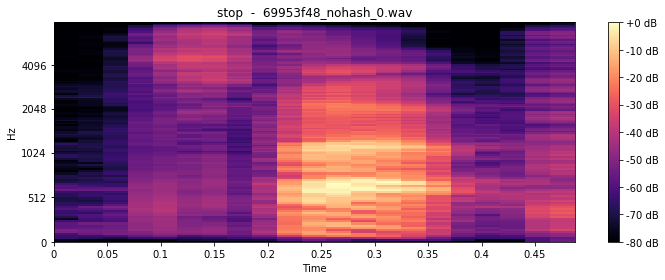

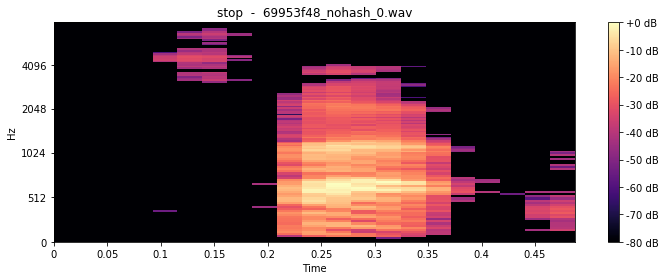

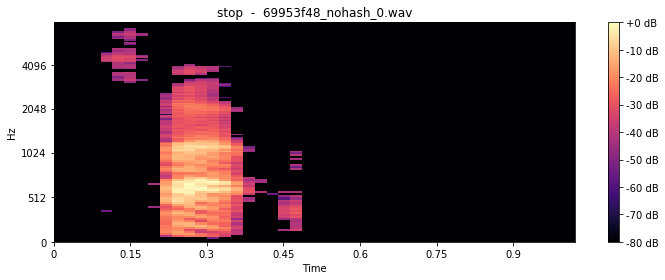

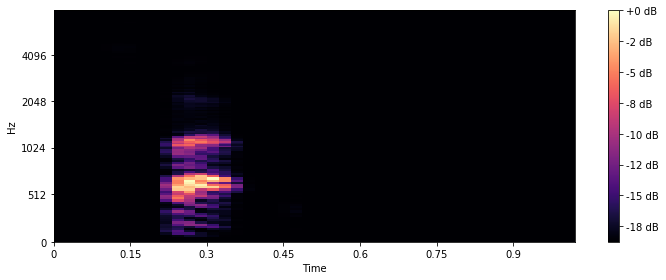

In [11]:
# DEMONSTRATION OF CHANGES TO DATASET

# SELECT THE INDEX HERE
indexToCheck = 687
# PLOT ORIGINAL SPECTROGRAM
demoOne = fileObjectToDataObject(audioFiles[indexToCheck], preProcess = False)
plotSpectrogram(demoOne)
# PLOT AFTER USING THRESHOLD
demoOne_Augment = fileObjectToDataObject(audioFiles[indexToCheck])
plotSpectrogram(demoOne_Augment)

# ADD SILENCE IF AUDIO IS LESS THAN 1 SEC
demoAsArray = [demoOne_Augment]
addSilenceToSet(demoAsArray, findMax = False)
plotSpectrogram(demoAsArray[0])

# PRINT NORMALIZED VERSION
stackedDemo = []
for i in range(len(demoAsArray)):
    stackedDemo.append(np.reshape(demoAsArray[i]['data'], [128,44 ]))
stackedDemo = normalizeArr(stackedDemo) 
plotNormalizedSpectrogram(stackedDemo[0])


In [9]:
# SAVE THE DATAFILE
pickle.dump((stackedTraining_Data, stackedTraining_Label), open('preprocessedAudio_Training_' +name+'.p', 'wb'))
pickle.dump((stackedValidation_Data, stackedValidation_Label), open('preprocessedAudio_Validation_'+name+'.p', 'wb'))